<h3>This model for the XC Data uses linear regression - a simple and basic tool for prediction</h3>

<p>Why linear regression?</p>
<p><ul><li>

    widely used
    <li>runs fast
    <li>easy to use (no tuning is required)
    <li>highly interpretable
    <li>basis for many other methods
    </ul></p>
    <p> The library used is Sci-kit Learn which facilitates general purpose machine learning in Python.</p>
    <p> We will be using feature engineering to read in the race results (times) for a particular runner and format them depending on the number of results we want to use for training our model in a sliding window.  Here is some terminology:
    <ul>
    <li>Date Time Features: these are components of the time step itself for each observation.
    <li>Lag Features: these are values at prior time steps.
    <li>Window Features: these are a summary of values over a fixed window of prior time steps - we will enter the size.</ul></p>
    
    





<h3>Evaluation Metrics</h3><p>

We will use the Mean Absolute Percentage Error (MAPE). It is a metric widely used in the field of time series forecasting, and refers to the average percentage of errors in the forecasts, disregarding the direction (above or below the true value).
</p><p>
In addition to this error, we will also evaluate the Mean Absolute Error (MAE), which is the mean of the absolute values of the errors. This way we know how much we are deviating from the real values in the original units.  As a comparison, we will also show the Error from the Last month value where the forecast for the next month is just the value of the variable in the last month and the Moving Average Error where the forecast for the next month is the average of the last X times (based on window or forecast size).
</p><p>
From a practical standpoint, in order to justify the use of linear regression instead of simpler methods, it should present an average error smaller than the error of the other options.</p>

<h3>You will be prompted to enter a runner id</h3><p>This will import all times available (data) from the complete file of XC times</p>

In [1]:
# from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
#sample id 409571
#sample id 1039492
id=int(input("enter the runner ID  "))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


enter the runner ID  409571


In [3]:
#The entire file is read
#This can be more efficient by removing features that this program does not use
data = pd.read_csv('final_boys_modeling_8_4.csv',header=0, low_memory=False)

data.head()

,ID1,ID,RunnerID,first,last,school,class_status_cat,class_status_num,time_sec,time_dec_min,...,county,ELEVATION,LATITUDE,LONGITUDE,HOURLYDRYBULBTEMPF,HOURLYRelativeHumidity,year,Temp_Celcius,Elevation_Cat,Dew_Point_Cat
0,1,42776,185469,Justin,Swink,West Forsyth,Junior,3,1139.4,18.99,...,Guilford,271.3,36.09690,-79.94320,81.0,54.0,2010.0,27.22222222,2.0,3.0
1,2,46744,185469,Justin,Swink,West Forsyth,Junior,3,1025.0,17.08,...,New Hanover,10.1,34.26750,-77.89970,75.0,69.0,2010.0,23.88888889,1.0,3.0
2,3,57289,185469,Justin,Swink,West Forsyth,Junior,3,1038.9,17.32,...,Forsyth,295.7,36.13361,-80.22222,58.0,41.0,2010.0,14.44444444,2.0,1.0
3,4,59824,185469,Justin,Swink,West Forsyth,Junior,3,1066.0,17.77,...,Forsyth,295.7,36.13361,-80.22222,50.0,54.0,2010.0,10,2.0,1.0
4,5,62272,185469,Justin,Swink,West Forsyth,Junior,3,1064.0,17.73,...,Mecklenburg,221.9,35.22360,-80.95520,45.0,35.0,2010.0,7.222222222,1.0,1.0


<h3>How many total race results do we have for this runner?</h3>

In [4]:
filterDF=data[data['RunnerID']==id]
row_count = len(filterDF.index)
print (row_count)


0


In [5]:
#we need to format the data in date time format
modeldata=filterDF.filter(items=['DATE', 'time_sec'])
modeldata.head()

,DATE,time_sec


In [38]:
modeldata['DATE']=pd.to_datetime(modeldata.DATE)
modeldata.head()

,DATE,time_sec
6624,2013-08-30,978.51
6625,2012-09-25,1093.00
6626,2012-10-16,1044.10
6627,2012-09-11,1063.00
6628,2012-09-08,1011.00


In [39]:
#lets make sure the dates are in order from earliest to latest
sortedData=modeldata.sort_values(by='DATE')

In [40]:
data = sortedData
data.head()

,DATE,time_sec
6646,2010-09-08,1060.6
6648,2010-09-11,1073.0
6644,2010-09-14,1185.0
6647,2010-09-25,1107.1
6649,2010-10-02,1051.0


In [41]:
##################### function
#create the Mean Absolute Percent Error calculation function its not already
#available in sci-kit learn
def mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

##################### end of function

#here we are creating a feature matrix for prediction
#you can change the number of races going in to the prediction
#x values are the values used for the prediction in the training model
#y values are the actual time that will be used in determining the error
#of the prediction

numtimes =int(input("Enter the number of race results you want to use for your prediction "))


Enter the number of race results you want to use for your prediction 2


In [42]:
data.head()

x_data = []
y_data = []

# Creates a feature matrix with values from previous 2 races
#for d in range(2,data.shape[0]):
#    x = data.iloc[d-2:d,1].values.ravel()
#    y = data.iloc[d].values[1]
#    x_data.append(x)
#    y_data.append(y)
for d in range(numtimes,data.shape[0]):
    x = data.iloc[d-numtimes:d,1].values.ravel()
    y = data.iloc[d].values[1]
    x_data.append(x)
    y_data.append(y)

x_data = np.array(x_data)
y_data = np.array(y_data)
x_data

array([[ 1060.6 ,  1073.  ],
       [ 1073.  ,  1185.  ],
       [ 1185.  ,  1107.1 ],
       [ 1107.1 ,  1051.  ],
       [ 1051.  ,  1069.34],
       [ 1069.34,  1073.03],
       [ 1073.03,  1082.12],
       [ 1082.12,  1054.21],
       [ 1054.21,  1025.  ],
       [ 1025.  ,  1043.78],
       [ 1043.78,  1001.  ],
       [ 1001.  ,  1037.94],
       [ 1037.94,  1050.78],
       [ 1050.78,  1000.  ],
       [ 1000.  ,   993.6 ],
       [  993.6 ,  1063.3 ],
       [ 1063.3 ,  1011.  ],
       [ 1011.  ,  1063.  ],
       [ 1063.  ,  1093.  ],
       [ 1093.  ,  1003.8 ],
       [ 1003.8 ,   981.6 ],
       [  981.6 ,  1044.1 ],
       [ 1044.1 ,  1028.1 ],
       [ 1028.1 ,  1015.8 ],
       [ 1015.8 ,   995.  ],
       [  995.  ,   978.51],
       [  978.51,   947.3 ]])

In [43]:
#the actual times that are used in calculating the
#accuracy of the model - for example with 2 feature (time) windows
#the 3rd is the first prediction
y_data

array([ 1185.  ,  1107.1 ,  1051.  ,  1069.34,  1073.03,  1082.12,
        1054.21,  1025.  ,  1043.78,  1001.  ,  1037.94,  1050.78,
        1000.  ,   993.6 ,  1063.3 ,  1011.  ,  1063.  ,  1093.  ,
        1003.8 ,   981.6 ,  1044.1 ,  1028.1 ,  1015.8 ,   995.  ,
         978.51,   947.3 ,   987.17])

In [44]:
#Lists to store the predictions of the models
y_pred = []
y_pred_last = []
y_pred_ma = []
y_true = []



#Iterate over the time series creating a new model each month
end = y_data.shape[0]
#altered range from length to numtimes here
for i in range(numtimes,end):

    x_train = x_data[:i,:]
    y_train = y_data[:i]
    
    x_test = x_data[i,:]
    y_test = y_data[i]


    model = LinearRegression(normalize=True)
    model.fit(x_train,y_train)

    y_pred.append(model.predict(x_test.reshape(1, -1))[0])
    y_pred_last.append(x_test[-1])
    y_pred_ma.append(x_test.mean())
    y_true.append(y_test)


#Transforms the lists into numpy arrays
y_pred = np.array(y_pred)
y_pred_last = np.array(y_pred_last)
y_pred_ma = np.array(y_pred_ma)
y_true = np.array(y_true)


#Print errors
print ('\nMean Absolute Percentage Error')
print ('MAPE Linear Regression', mape(y_pred,y_true))
print ('MAPE Last Value Benchmark', mape(y_pred_last,y_true))
print ('MAPE Moving Average Benchmark', mape(y_pred_ma,y_true))


print ('\nMean Absolute Error')
print ('MAE Linear Regression', mean_absolute_error(y_pred,y_true))
print ('MAE Last Value Benchmark', mean_absolute_error(y_pred_last,y_true))
print ('MAE Moving Average Benchmark', mean_absolute_error(y_pred_ma,y_true))




Mean Absolute Percentage Error
MAPE Linear Regression 5.1230685331
MAPE Last Value Benchmark 3.22739271588
MAPE Moving Average Benchmark 3.38616748767

Mean Absolute Error
MAE Linear Regression 52.7133408989
MAE Last Value Benchmark 33.0972
MAE Moving Average Benchmark 34.6788


<h3>

All of these are loss functions, because we want to minimize them.</h3>
<p>Next we will see the intercept and the coefficients of the linear regression equation</p>

In [45]:
#to get the parameters for the equation - returned in the form of an array
#Note that this is a linear equation, so to get the prediction for yourself, 
#you want to form an equation such that your prediction, 
#y = sum([input[i] * params[i]])
#params = model.coef_ and model.intercept
print ("The linear equation intercept is ")
print (model.intercept_)
print ("The coefficients are ")
print (model.coef_)

The linear equation intercept is 
469.570143169
The coefficients are 
[ 0.00281001  0.54243758]


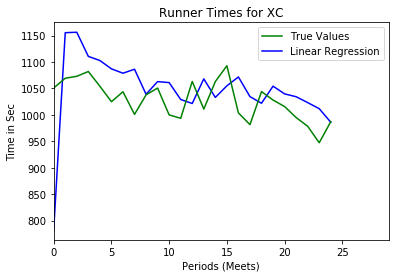

In [46]:
#print chart
from matplotlib import pyplot as plt
plt.title('Runner Times for XC')
plt.ylabel('Time in Sec')
plt.xlabel(u'Periods (Meets)')
reg_val, = plt.plot(y_pred,color='b',label=u'Linear Regression')
true_val, = plt.plot(y_true,color='g', label='True Values')
plt.xlim([0,row_count])
plt.legend(handles=[true_val,reg_val])
plt.show()

<h3>Let's try a new prediction</h3>

In [53]:
### New Prediction ###

# predict for a new observation, this uses a two cell floating window
print ("The last two times for runner_id 1039492 are: 978, 947")
time1 =int(input("enter the first time in seconds with no decimals and press enter  "))
time2 =int(input("enter the first time in seconds with no decimals and press enter  "))
new_X = np.array([time1, time2])
new_prediction = model.predict(new_X.reshape(1, -1))
print ("Your time for your next race is estimated to be ")
print (new_prediction)
print (" seconds")

The last two times for runner_id 1039492 are: 978, 947
enter the first time in seconds with no decimals and press enter  978
enter the first time in seconds with no decimals and press enter  947
Your time for your next race is estimated to be 
[ 986.00672106]
 seconds



<h3>Comparing linear regression with other models</h3>

<p>Advantages of linear regression:<br>
<ul><li>
    Simple to explain
    <li>Highly interpretable
    <li>Model training and prediction are fast
    <li>No tuning is required (excluding regularization)
    <li>Features don't need scaling
    <li>Can perform well with a small number of observations which we have when inputting one runner at a time</ul>

</p><p>Disadvantages of linear regression:<br>
<ul><li>
    Presumes a linear relationship between the features and the response
    <li>Performance is (generally) not competitive with the best supervised learning methods due to high bias
   <li> Sensitive to irrelevant features - we are only use time in this simple model
   <li> Can't automatically learn feature interactions</u></p>



<p>References:</p>
<p><a href="http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py">Scikit-Learn</a></p>
<p><a href="http://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/">Machine Learning Mastery</a>
</p>